# Data Visualization

In this notebook, we demonstrate various examples of data visualization using [`matplotlib`](https://matplotlib.org), [`seaborn`](https://seaborn.pydata.org), and [`altair`](https://altair-viz.github.io/). The data is obtained by querying a DuckDB database and performing most of the computation on the database side.

Copyright Marcel Maltry, Joris Nix & Jens Dittrich, [Big Data Analytics Group](https://bigdata.uni-saarland.de/), [CC-BY-SA](https://creativecommons.org/licenses/by-sa/4.0/legalcode)

# Setup

Again, we use the IMDb data provided by https://relational.fit.cvut.cz/dataset/IMDb. This time, we use the full dataset, so we start by importing it from .csv files into our local DuckDB database.

In [1]:
import duckdb

data_path = 'data/IMDb_full/'

# start a in-memory database
conn = duckdb.connect(database=':memory:')

In [2]:
# create schemas
conn.execute("""
CREATE TABLE actors
(
    id int PRIMARY KEY,
    first_name varchar,
    last_name varchar,
    gender char
);""")

conn.execute("""
CREATE TABLE movies
(
    id int PRIMARY KEY,
    name varchar,
    year int,
    rank float
);""")

conn.execute("""
CREATE TABLE roles
(
    actor_id int REFERENCES actors(id),
    movie_id int REFERENCES movies(id),
    role varchar
);""")

conn.execute("""
CREATE TABLE movies_genres
(
    movie_id int REFERENCES movies(id),
    genre varchar
);""")

conn.execute("""
CREATE TABLE fav_actors
(
    actor_id int REFERENCES actors(id)
);""")

conn.execute("""
CREATE TABLE directors
(
    id int PRIMARY KEY,
    first_name varchar,
    last_name varchar
);""")

conn.execute("""
CREATE TABLE movies_directors
(
    director_id int REFERENCES directors(id),
    movie_id int REFERENCES movies(id)
);""");

**Note:** Reading the data takes a few seconds.

In [3]:
%%time

# Data source: https://relational.fit.cvut.cz/dataset/IMDb
# Information courtesy of IMDb (http://www.imdb.com). Used with permission.
#
# Notice: The data can only be used for personal and non-commercial use and must not
# be altered/republished/resold/repurposed to create any kind of online/offline
# database of movie information (except for individual personal use).

conn.execute(f"COPY actors FROM '{data_path}actors.csv' (FORMAT CSV, HEADER, DELIMITER '\t');")
conn.execute(f"COPY movies FROM '{data_path}movies.csv' (FORMAT CSV, HEADER, DELIMITER '\t', NULL 'NULL');")
conn.execute(f"COPY roles FROM '{data_path}roles.csv' (FORMAT CSV, HEADER, DELIMITER '\t');")
conn.execute(f"COPY movies_genres FROM '{data_path}movies_genres.csv' (FORMAT CSV, HEADER, DELIMITER '\t');")
conn.execute(f"COPY fav_actors FROM '{data_path}fav_actors.csv' (FORMAT CSV, HEADER, DELIMITER '\t');");
conn.execute(f"COPY directors FROM '{data_path}directors.csv' (FORMAT CSV, HEADER, DELIMITER '\t');");
conn.execute(f"COPY movies_directors FROM '{data_path}movies_directors.csv' (FORMAT CSV, HEADER, DELIMITER '\t');");

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

CPU times: user 10.8 s, sys: 290 ms, total: 11.1 s
Wall time: 7.22 s


# Barplot

We first want to visualize the amount of movies produced per year since 1960. We can simply query this information by performing a `GROUP BY` on year and counting the members per group as follows:
```SQL
SELECT year, COUNT(*)
FROM
    movies m
WHERE year >= 1960
GROUP BY year
ORDER BY year
```
From the query result, we extract the years and counts into two separate lists.

In [4]:
# Query number of movies by year
movies_query = """
SELECT year, COUNT(*)
FROM
    movies m
WHERE year >= 1960
GROUP BY year
ORDER BY year
"""
conn.execute(movies_query)
movies_result = conn.fetchall()

years = [tup[0] for tup in movies_result]
counts = [tup[1] for tup in movies_result]

With `matplotlib`, we can visualize the query result as a so called bar plot. This type of plot shows one bar for each year. On the x-axis, we have all the years from 1960 to 2008 and on the y-axis it shows the amount of movies produced in this year.

To achieve better control over the size of the plot, we define a subplot and then plot the bar plot on the axis returned by `plt.subplot()`. `bar()` takes as argument `x`, the number of bars on the x-axis, and `y` the values for each of the bars. We also specify the labels for the ticks on the x-axis and rotate them for better readability.

Note that the data seems to be from around 2003 which is why there seem to be less movies in the following years.

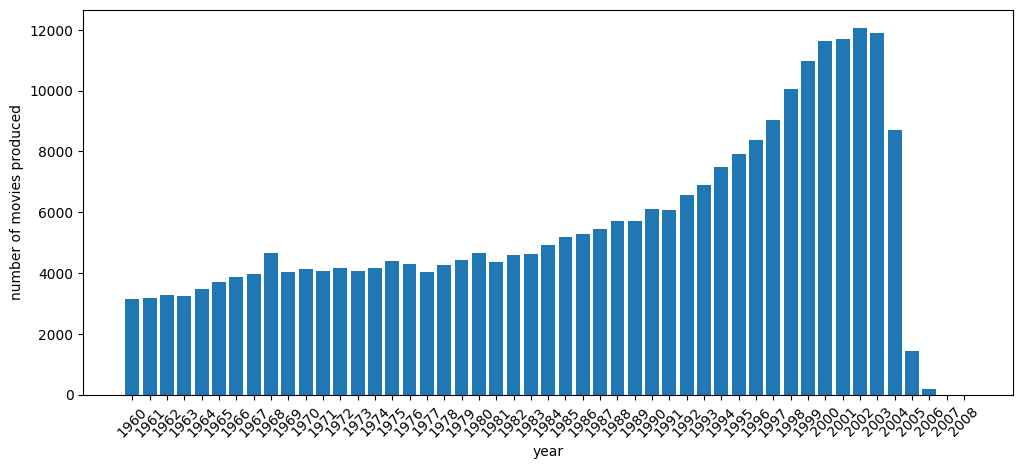

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define subplots and size
fig, ax = plt.subplots(1,1, figsize=(12,5))

# Plot barplot
x = range(len(years))
y = counts
ax.bar(x, y, tick_label=years)

# Adjustments
ax.set_xlabel('year')
ax.set_ylabel('number of movies produced')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.show()

# Heatmap

Next, we are interested in the genres of movies our favorite actors played in. For each of our favorite actors and each movie genre, we want to count the amount of movies of that genre the actor played in. We can achieve this by finding all the movies our favorite actors played in and then by grouping on both the actor and the genres as follows:
```SQL
SELECT
    concat(a.first_name,' ',a.last_name) AS name,
    mg.genre as genre,
    COUNT(*) AS cnt
FROM
    movies m,
    movies_genres mg,
    roles r,
    actors a,
    fav_actors fa
WHERE
    a.id = r.actor_id AND
    r.movie_id = m.id AND
    m.id = mg.movie_id AND
    fa.actor_id = a.id
GROUP BY a.id, mg.genre
ORDER BY name, genre;
```
Note that we insert all resulting tuples into a dictionary mapping a tuple of actor and genre to the number of movies of that genre the actor played a role in. We also query and extract the names of the actors and all the genres.

In [6]:
# Query number of movies by favorite actor and genre
group_query = """
SELECT
    concat(a.first_name,' ',a.last_name) AS name,
    mg.genre as genre,
    COUNT(*) AS cnt
FROM
    movies m,
    movies_genres mg,
    roles r,
    actors a,
    fav_actors fa
WHERE
    a.id = r.actor_id AND
    r.movie_id = m.id AND
    m.id = mg.movie_id AND
    fa.actor_id = a.id
GROUP BY a.id, a.first_name, a.last_name, mg.genre
ORDER BY name, genre;
"""
conn.execute(group_query)
group_result = conn.fetchall()

# Insert result into dictionary
cnt_dict = dict()
for tup in group_result:
    cnt_dict[(tup[0], tup[1])] = tup[2]

# Query names of favorite actors
actors_query = """
SELECT
    concat(a.first_name,' ',a.last_name) AS name
FROM
    actors a,
    fav_actors fa
WHERE
    fa.actor_id = a.id
ORDER BY name;
"""
conn.execute(actors_query)
actors = [tup[0] for tup in conn.fetchall()]

# Query all genres
genres_query = "SELECT DISTINCT genre from movies_genres ORDER BY genre;"
conn.execute(genres_query)
genres = [tup[0] for tup in conn.fetchall()]

Having gathered all the data, we decided to visualize the result as a heat map. You can think of a heatmap as a color coded pivot table where lower numbers and higher numbers share similar colors, respectively.

Before being able to visualize the query results as a heatmap, we have to transform our query result into a pivot table. We start by initializing an pivot table with zero in each cell. We then enter all the numbers from the dictionary into the pivot table. Note that if a combination of actor and genre does not exist, we enter 0 into the pivot table.

In [7]:
import numpy as np

# Build heat map
pivottable = np.zeros(shape=(len(actors), len(genres)))

for i, actor in enumerate(actors):
    for j, genre in enumerate(genres):
        pivottable[i][j] = cnt_dict.get((actor, genre), 0)

We now visualize the pivot table as a heatmap using `seaborn`. The function `heatmap()` takes as arguments `data` in form of a two dimensional array (our pivot table) along with some parameters that let us specify some visual components such as the tick lablels and the scholor scheme. We again call `subplots()` to be able to set a size for the plot. This time, we define two subplots to be able to showcase different coloring schemes.

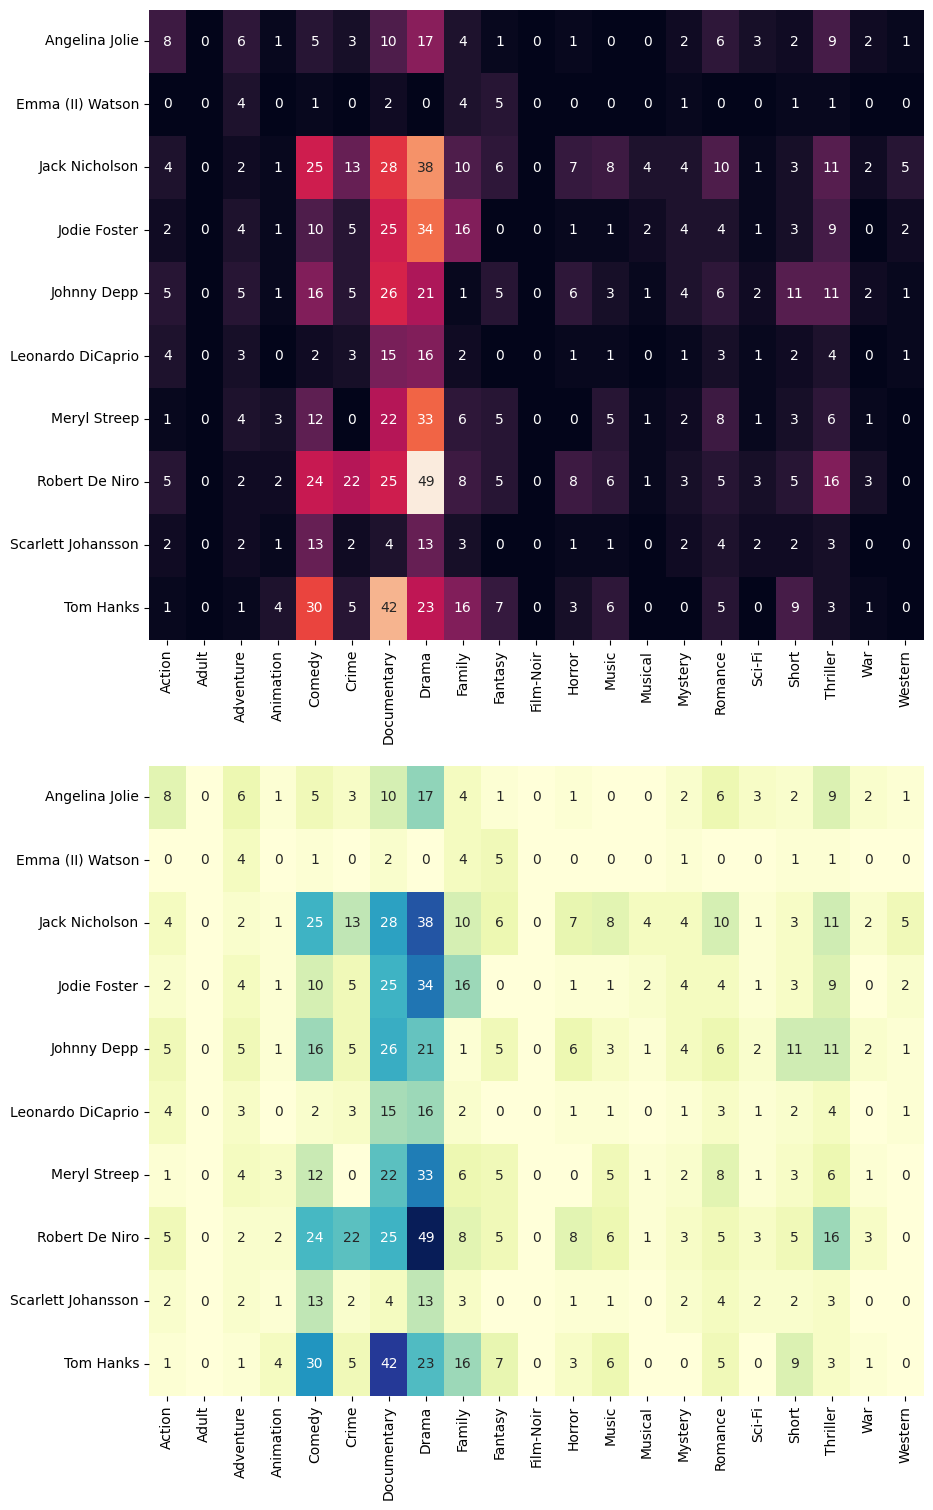

In [8]:
import seaborn as sns
%matplotlib inline

fig, ax = plt.subplots(2, 1, figsize=(10,18))

# Plot heatmap
sns.heatmap(pivottable, ax=ax[0], annot=True,
            xticklabels=genres, yticklabels=actors, cbar=False)#, cmap="YlGnBu", cbar=False)

# Plot heatmap with other color scheme
sns.heatmap(pivottable, ax=ax[1], annot=True,
            xticklabels=genres, yticklabels=actors, cbar=False, cmap="YlGnBu")
plt.show()

# Wordcloud

Now, we want to visualize the most common words in movie titles using a wordcloud. For this, we use the [WorldCloud](http://amueller.github.io/word_cloud/) Python package. 

In this visualization, we can arbitrarily limit the set of movies. By default, we simply use all movies.

```SQL
SELECT name
FROM movies;
```

Note that we extract all movie titles as a Pandas DataFrame. Afterwards, we construct one large string by concatenating all movie titles.

In [9]:
# Query all movie titles
movie_titles_q = """
SELECT name
FROM movies;
"""
conn.execute(movie_titles_q)
movie_titles = conn.fetchdf()

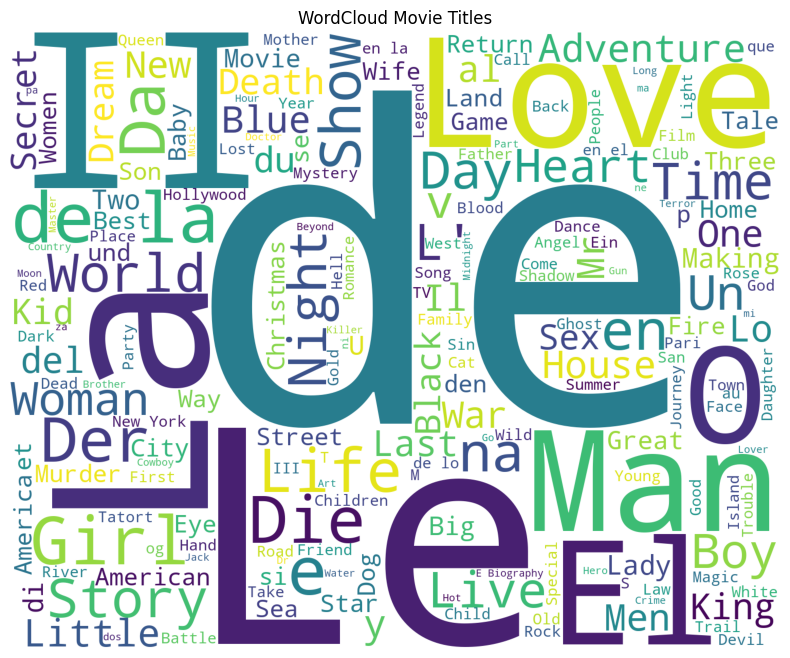

In [10]:
from wordcloud import WordCloud, STOPWORDS

# concatenate all movie titles
text = movie_titles['name'].str.cat(sep=' ', na_rep=' ')

# optinally update the stopwords
# STOPWORDS.update(['de', 'La', 'Le', 'II', 'e', 'O'])

fig, ax = plt.subplots(figsize=(10,8))
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=1500,
                      height=1200
                     ).generate(text)
ax.imshow(wordcloud)
ax.set_title('WordCloud Movie Titles')
plt.axis('off')
plt.show()

# Pie Chart

We will use this type of visualization to show the top 10 directors according to the number of movies they directed. For this, we use the `movies_directors` table and group by the `director_id`.

```SQL
SELECT
    d.first_name, d.last_name, SUM(md.movie_id)
FROM
    directors AS d,
    movie_directors AS md
WHERE
    d.id = md.director_id
GROUP BY
    md.director_id, d.first_name, d.last_name
ORDER BY
    SUM(md.movie_id)
LIMIT 10;
```

In [11]:
# Query top 10 directors according to the number of movies they directed
director_movie_count_q = """
SELECT
    d.first_name, d.last_name, COUNT(md.movie_id)
FROM
    directors AS d,
    movies_directors AS md
WHERE
    d.id = md.director_id
GROUP BY
    md.director_id, d.first_name, d.last_name
ORDER BY
    COUNT(md.movie_id) DESC
LIMIT 10;

"""
conn.execute(director_movie_count_q)
director_movie_count = conn.fetchall()

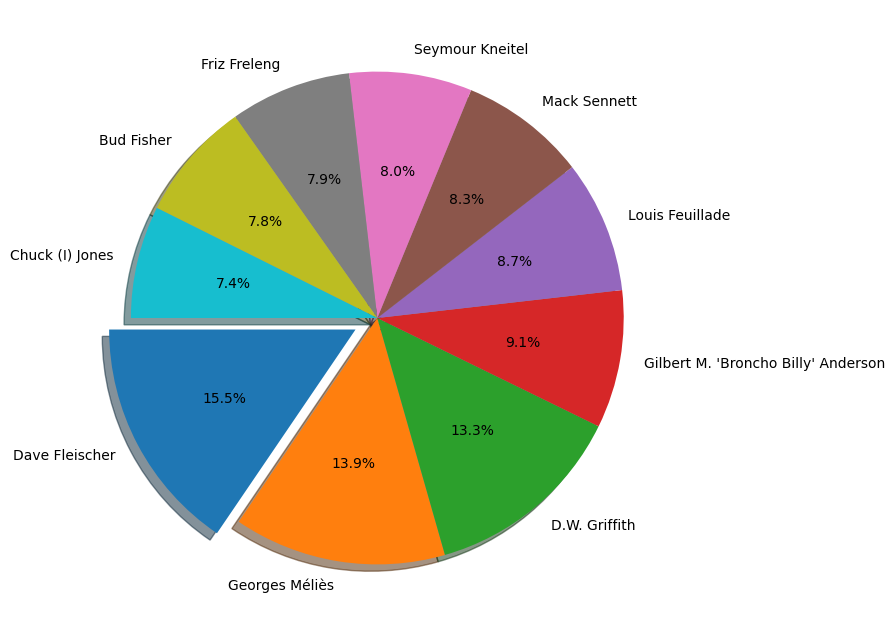

In [12]:
names = [f'{tup[0]} {tup[1]}' for tup in director_movie_count]
counts = [tup[2] for tup in director_movie_count]

explode = [0]*len(names)
explode[0] = 0.1

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(counts, labels=names, autopct='%1.1f%%', explode=explode, shadow=True, startangle=180)

plt.show()

# Violin Plot

A violin plot is a combination of boxplot and kernel density estimate, highlighting the underlying distribution.

In the following plot, want want to visualize for different genres the ranks of their respective movies. 
The `movies_genres` table contains a mapping of each movie to the corresponding genre. By joining this table with the `movies`, we get access to the rank.

```sql
SELECT
    mg.genre, m.rank
FROM
    movies AS m,
    movies_genres AS mg
WHERE
    m.id = mg.movie_id AND
    mg.genre in ('Documentary', 'Comedy', 'Action', 'Thriller', 'Horror');
```
In this query, we also restrict the genre to be one of the following five: `Documentary`, `Comedy`, `Action`, `Thriller`, and `Horror`.

In [13]:
q = """
SELECT
    mg.genre, m.rank
FROM
    movies AS m,
    movies_genres AS mg
WHERE
    m.id = mg.movie_id AND
    mg.genre in ('Documentary', 'Comedy', 'Action', 'Thriller', 'Horror');
"""
conn.execute(q)
genre_movie_rank = conn.fetchdf()

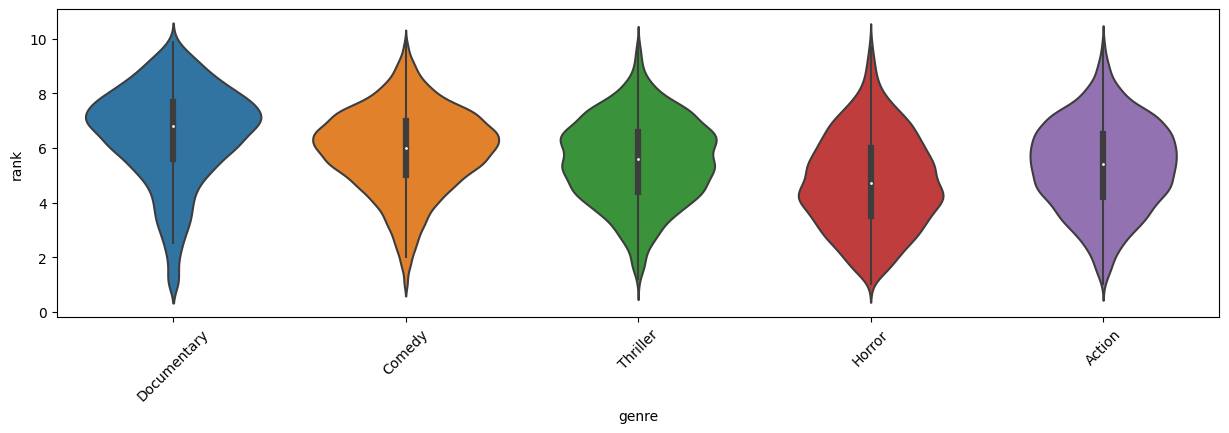

In [14]:
fig, ax = plt.subplots(figsize=(15,4))
sns.violinplot(data=genre_movie_rank, x='genre', y='rank', ax=ax)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.show()

# Stacked Bar Chart

Next, we want to visualize the number of movies per year for each of our favorite actors since 1980. We will display this data as a stacked bar chart. In contrast to the previous visualizations, we now use [altair](https://altair-viz.github.io/), a declarative visualization library for Python.

To obtain the relevant data, we need join the required relations and group by the actor and year. In the `SELECT` clause, we concatenate the first and last name und compute the number of movies using `COUNT()`.

```sql
SELECT
    a.id, concat(a.first_name, ' ', a.last_name) AS name, m.year, COUNT(m.id) AS num_movies
FROM
    actors AS a,
    fav_actors AS fa,
    movies AS m,
    roles AS r
WHERE
    a.id = fa.actor_id AND
    a.id = r.actor_id AND
    r.movie_id = m.id AND
    m.year > 1980
GROUP BY
    a.id, a.first_name, a.last_name, m.year
ORDER BY
    m.year
```

In [15]:
q = """
SELECT
    a.id, CONCAT(a.first_name, ' ', a.last_name) AS name, m.year, COUNT(m.id) AS num_movies
FROM
    actors AS a,
    fav_actors AS fa,
    movies AS m,
    roles AS r
WHERE
    a.id = fa.actor_id AND
    a.id = r.actor_id AND
    r.movie_id = m.id AND
    m.year > 1980
GROUP BY
    a.id, a.first_name, a.last_name, m.year
ORDER BY
    m.year
"""
conn.execute(q)
actor_movie_count = conn.fetchdf()

In [16]:
import altair as alt
from vega_datasets import data

alt.Chart(actor_movie_count).mark_bar().encode(
    alt.X('year:N'),
    alt.Y('num_movies:Q'),
    alt.Color('name')
).properties(
    width=800,
    height=400
)

alt.Chart(...)

# Stacked Area Chart

The stacked area chart is a variant of the stacked bar plot. Here, we want to visualize the number of movies per year for each genre since 1960. The query groups the movies according to their year of release and the genre. Note, that a movie can have multiple different genres.

```sql
SELECT
    mg.genre, m.year, COUNT(m.id) AS num_movies
FROM
    movies AS m,
    movies_genres AS mg
WHERE
    m.id = mg.movie_id AND
    m.year > 1960
GROUP BY
    mg.genre, m.year
ORDER BY
    m.year
```

In [17]:
q = """
SELECT
    mg.genre, m.year, COUNT(m.id) AS num_movies
FROM
    movies AS m,
    movies_genres AS mg
WHERE
    m.id = mg.movie_id AND
    m.year > 1960
GROUP BY
    mg.genre, m.year
ORDER BY
    m.year
"""
conn.execute(q)
genre_movie_count = conn.fetchdf()

In [18]:
import altair as alt
from vega_datasets import data

alt.Chart(genre_movie_count).mark_area().encode(
    alt.X('year:N'),
    alt.Y('num_movies:Q'),
    alt.Color('genre')
).properties(
    width=800,
    height=400
).configure_range(
    category={'scheme': 'category20'}
)

alt.Chart(...)

# Interactive Chart

In [19]:
# Query number of movies by favorite actor and genre
q = """
SELECT
    concat(a.first_name,' ',a.last_name) AS name,
    mg.genre as genre,
    COUNT(*) AS num_movies
FROM
    movies m,
    movies_genres mg,
    roles r,
    actors a,
    fav_actors fa
WHERE
    a.id = r.actor_id AND
    r.movie_id = m.id AND
    m.id = mg.movie_id AND
    fa.actor_id = a.id
GROUP BY a.id, a.first_name, a.last_name, mg.genre
ORDER BY name, genre;
"""
conn.execute(q)
actor_genre_count = conn.fetchdf()

In [20]:
# create selection that allows to select a single chart element & tie it to "x"
# more on selections: https://altair-viz.github.io/altair-viz-v4/user_guide/interactions.html
click = alt.selection(type="single", encodings=['x'])

# create heatmap
heat = alt.Chart(actor_genre_count).mark_rect().encode(
    alt.X('genre:N'),
    alt.Y('name:N'),
    alt.Color('num_movies:Q',
            scale=alt.Scale(scheme='greenblue'),
            legend=alt.Legend(title='Number of Movies'))
).properties(
    width=700,
    height=400
)

# create 'circle' chart where the size represents the number of movies and add it to the heatmap
circ = heat.mark_point().encode(
    alt.ColorValue('grey'),
    alt.Size('num_movies:Q',
        legend=alt.Legend(title='Number of Movies')
    )
).transform_filter(
    click
)

# create bar chart showing the total number of movies for each genre
bar = alt.Chart(actor_genre_count).mark_bar().encode(
    alt.X('genre:N'),
    alt.Y('sum(num_movies):Q', title='Sum of Movies'),
    color=alt.condition(click, alt.ColorValue("steelblue"), alt.ColorValue("grey"))
).properties(
    width=700,
    height=200
).add_selection(click)

heat + circ & bar

alt.VConcatChart(...)